Визуализация активации в свёрточных нейронных сетях на примере распознавания чисел из датасета MNIST.
![mnist.png](attachment:mnist.png)
Визуализируем активации с помощью утилиты `keract`.

In [18]:
!cat /etc/*release*

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=22.04
DISTRIB_CODENAME=jammy
DISTRIB_DESCRIPTION="Ubuntu 22.04.3 LTS"
PRETTY_NAME="Ubuntu 22.04.3 LTS"
NAME="Ubuntu"
VERSION_ID="22.04"
VERSION="22.04.3 LTS (Jammy Jellyfish)"
VERSION_CODENAME=jammy
ID=ubuntu
ID_LIKE=debian
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
UBUNTU_CODENAME=jammy


In [16]:
!nvidia-smi

Wed Jan 17 14:42:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0              32W /  70W |    645MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [17]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [1]:
!pip install keract

In [2]:
import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import activations
from keract import get_activations, display_activations

In [3]:
# Различные константы
IMG_WIDTH, IMG_HEIGHT = 28, 28
BATCH_SIZE = 250
EPOCHS = 8
NUM_CLASSES = 10
VALIDATION_SPLIT = 0.2
VERBOSITY = 1

In [4]:
# Загружаем датасет MNIST.
(input_train, target_train), (input_test, target_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
# Какой тип данных у input_train.
print(type(input_train))

<class 'numpy.ndarray'>


In [6]:
# Какая размерность у input_train.
print(input_train.shape)

(60000, 28, 28)


[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

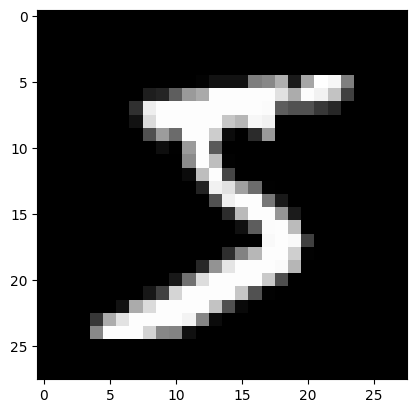

In [7]:
import matplotlib.pyplot as plt

# Визуализируем пример изображения из обучающей выборки.
print(input_train[0])
plt.imshow(input_train[0], cmap='gray')

In [8]:
# Подготавливаем данные.
input_train = input_train.reshape(input_train.shape[0], IMG_WIDTH, IMG_HEIGHT, 1)
input_test = input_test.reshape(input_test.shape[0], IMG_WIDTH, IMG_HEIGHT, 1)
input_shape = (IMG_WIDTH, IMG_HEIGHT, 1)


# Нормализуем данные (0-255 -> 0-1.0).

# В Python 2 нужно было предварительно явно преобразовать из целых чисел к числам с плавающей точкой,
# оператор деления при целочисленных операндах производил целочисленное деление (отбрасывается дробная часть). 42 / 100 = 0 (не 0.42)
# В Python 3 операнды всегда приводятся к числам с плавающей точкой. Для целочисленного деления введён отдельный оператор // .
#input_train = input_train.astype('float32')
#input_test = input_test.astype('float32')

input_train = input_train / 255
input_test = input_test / 255


target_train = tensorflow.keras.utils.to_categorical(target_train, NUM_CLASSES)
target_test = tensorflow.keras.utils.to_categorical(target_test, NUM_CLASSES)

In [9]:
# У input_train появилось ещё одно измерение.
# Каждое значение обернули в массив.
# Явно указали, что у каждого пикселя один канал - интенсивность оттенка серого.
# Глубокие нейронные сети чаще работают с данными большой размерности.
# Каналы каждого пикселя (1 или 3) должны быть обернуты в своё измерение многомерного массива.
print(input_train.shape)

(60000, 28, 28, 1)


In [10]:
# Значения преобразовались к числам с плавающей точкой.
print(input_train[0])

[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0. 

In [11]:
# Либо загружаем обученную модель.
# model = load_model("cnn_mnist_classification")

In [12]:
# Либо создаём модель.
model = Sequential()
model.add(Conv2D(6, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(10, kernel_size=(3, 3), activation='relu', padding='same'))
#output = Conv2D(10, kernel_size=(5, 5), activation='relu')(input)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

In [13]:
# И обучаем её.
model.compile(
    loss=tensorflow.keras.losses.categorical_crossentropy,
    optimizer=tensorflow.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model.fit(
    input_train,
    target_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSITY,
    validation_split=VALIDATION_SPLIT
)

# Сохраняем модель.
model.save("cnn_mnist_classification")

Epoch 1/8
192/192 [==============================] - 7s 11ms/step - loss: 0.3440 - accuracy: 0.9078 - val_loss: 0.1325 - val_accuracy: 0.9644
Epoch 2/8
192/192 [==============================] - 2s 11ms/step - loss: 0.1025 - accuracy: 0.9691 - val_loss: 0.0806 - val_accuracy: 0.9758
Epoch 3/8
192/192 [==============================] - 3s 16ms/step - loss: 0.0673 - accuracy: 0.9792 - val_loss: 0.0612 - val_accuracy: 0.9821
Epoch 4/8
192/192 [==============================] - 2s 9ms/step - loss: 0.0477 - accuracy: 0.9855 - val_loss: 0.0551 - val_accuracy: 0.9830
Epoch 5/8
192/192 [==============================] - 2s 10ms/step - loss: 0.0348 - accuracy: 0.9895 - val_loss: 0.0552 - val_accuracy: 0.9838
Epoch 6/8
192/192 [==============================] - 2s 12ms/step - loss: 0.0297 - accuracy: 0.9908 - val_loss: 0.0547 - val_accuracy: 0.9829
Epoch 7/8
192/192 [==============================] - 2s 11ms/step - loss: 0.0231 - accuracy: 0.9931 - val_loss: 0.0485 - val_accuracy: 0.9854
Epoch 8

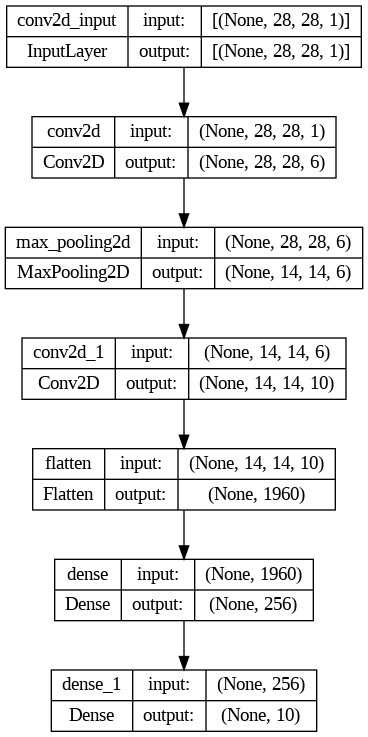

In [14]:
# Визуализируем модель.
plot_model(model, show_shapes = True)

conv2d_input (1, 28, 28, 1) 


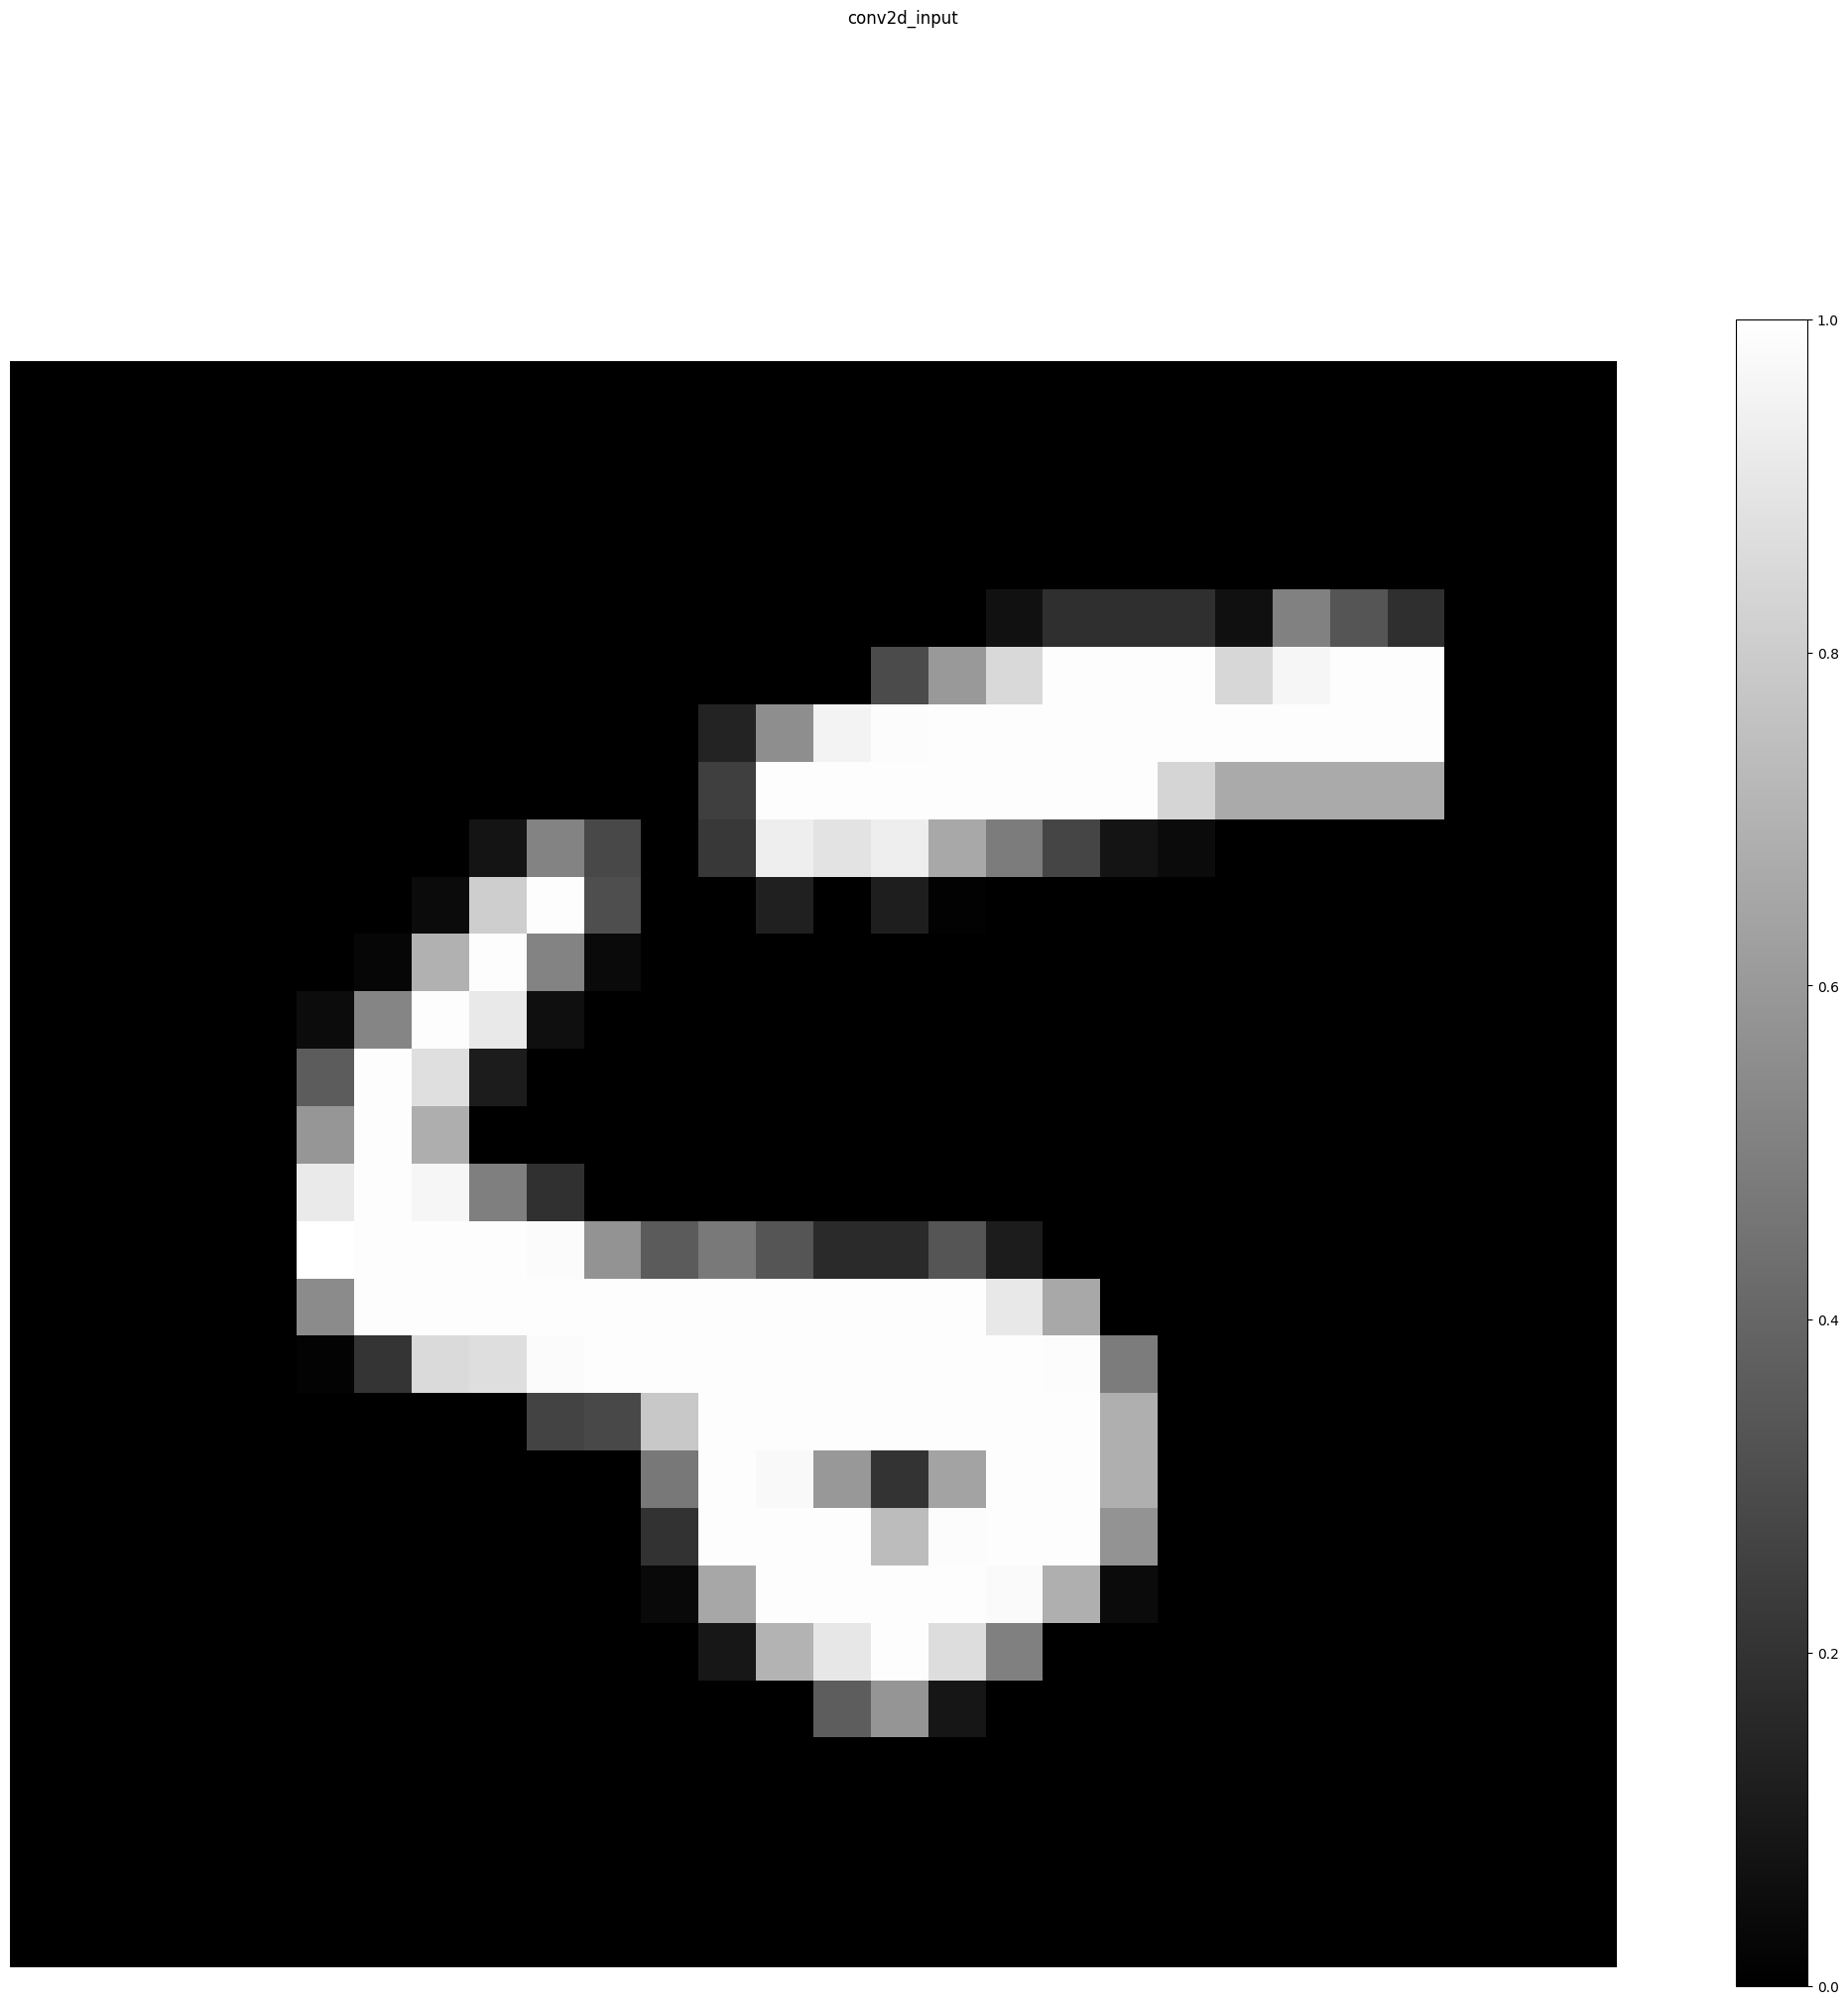

conv2d (1, 28, 28, 6) 


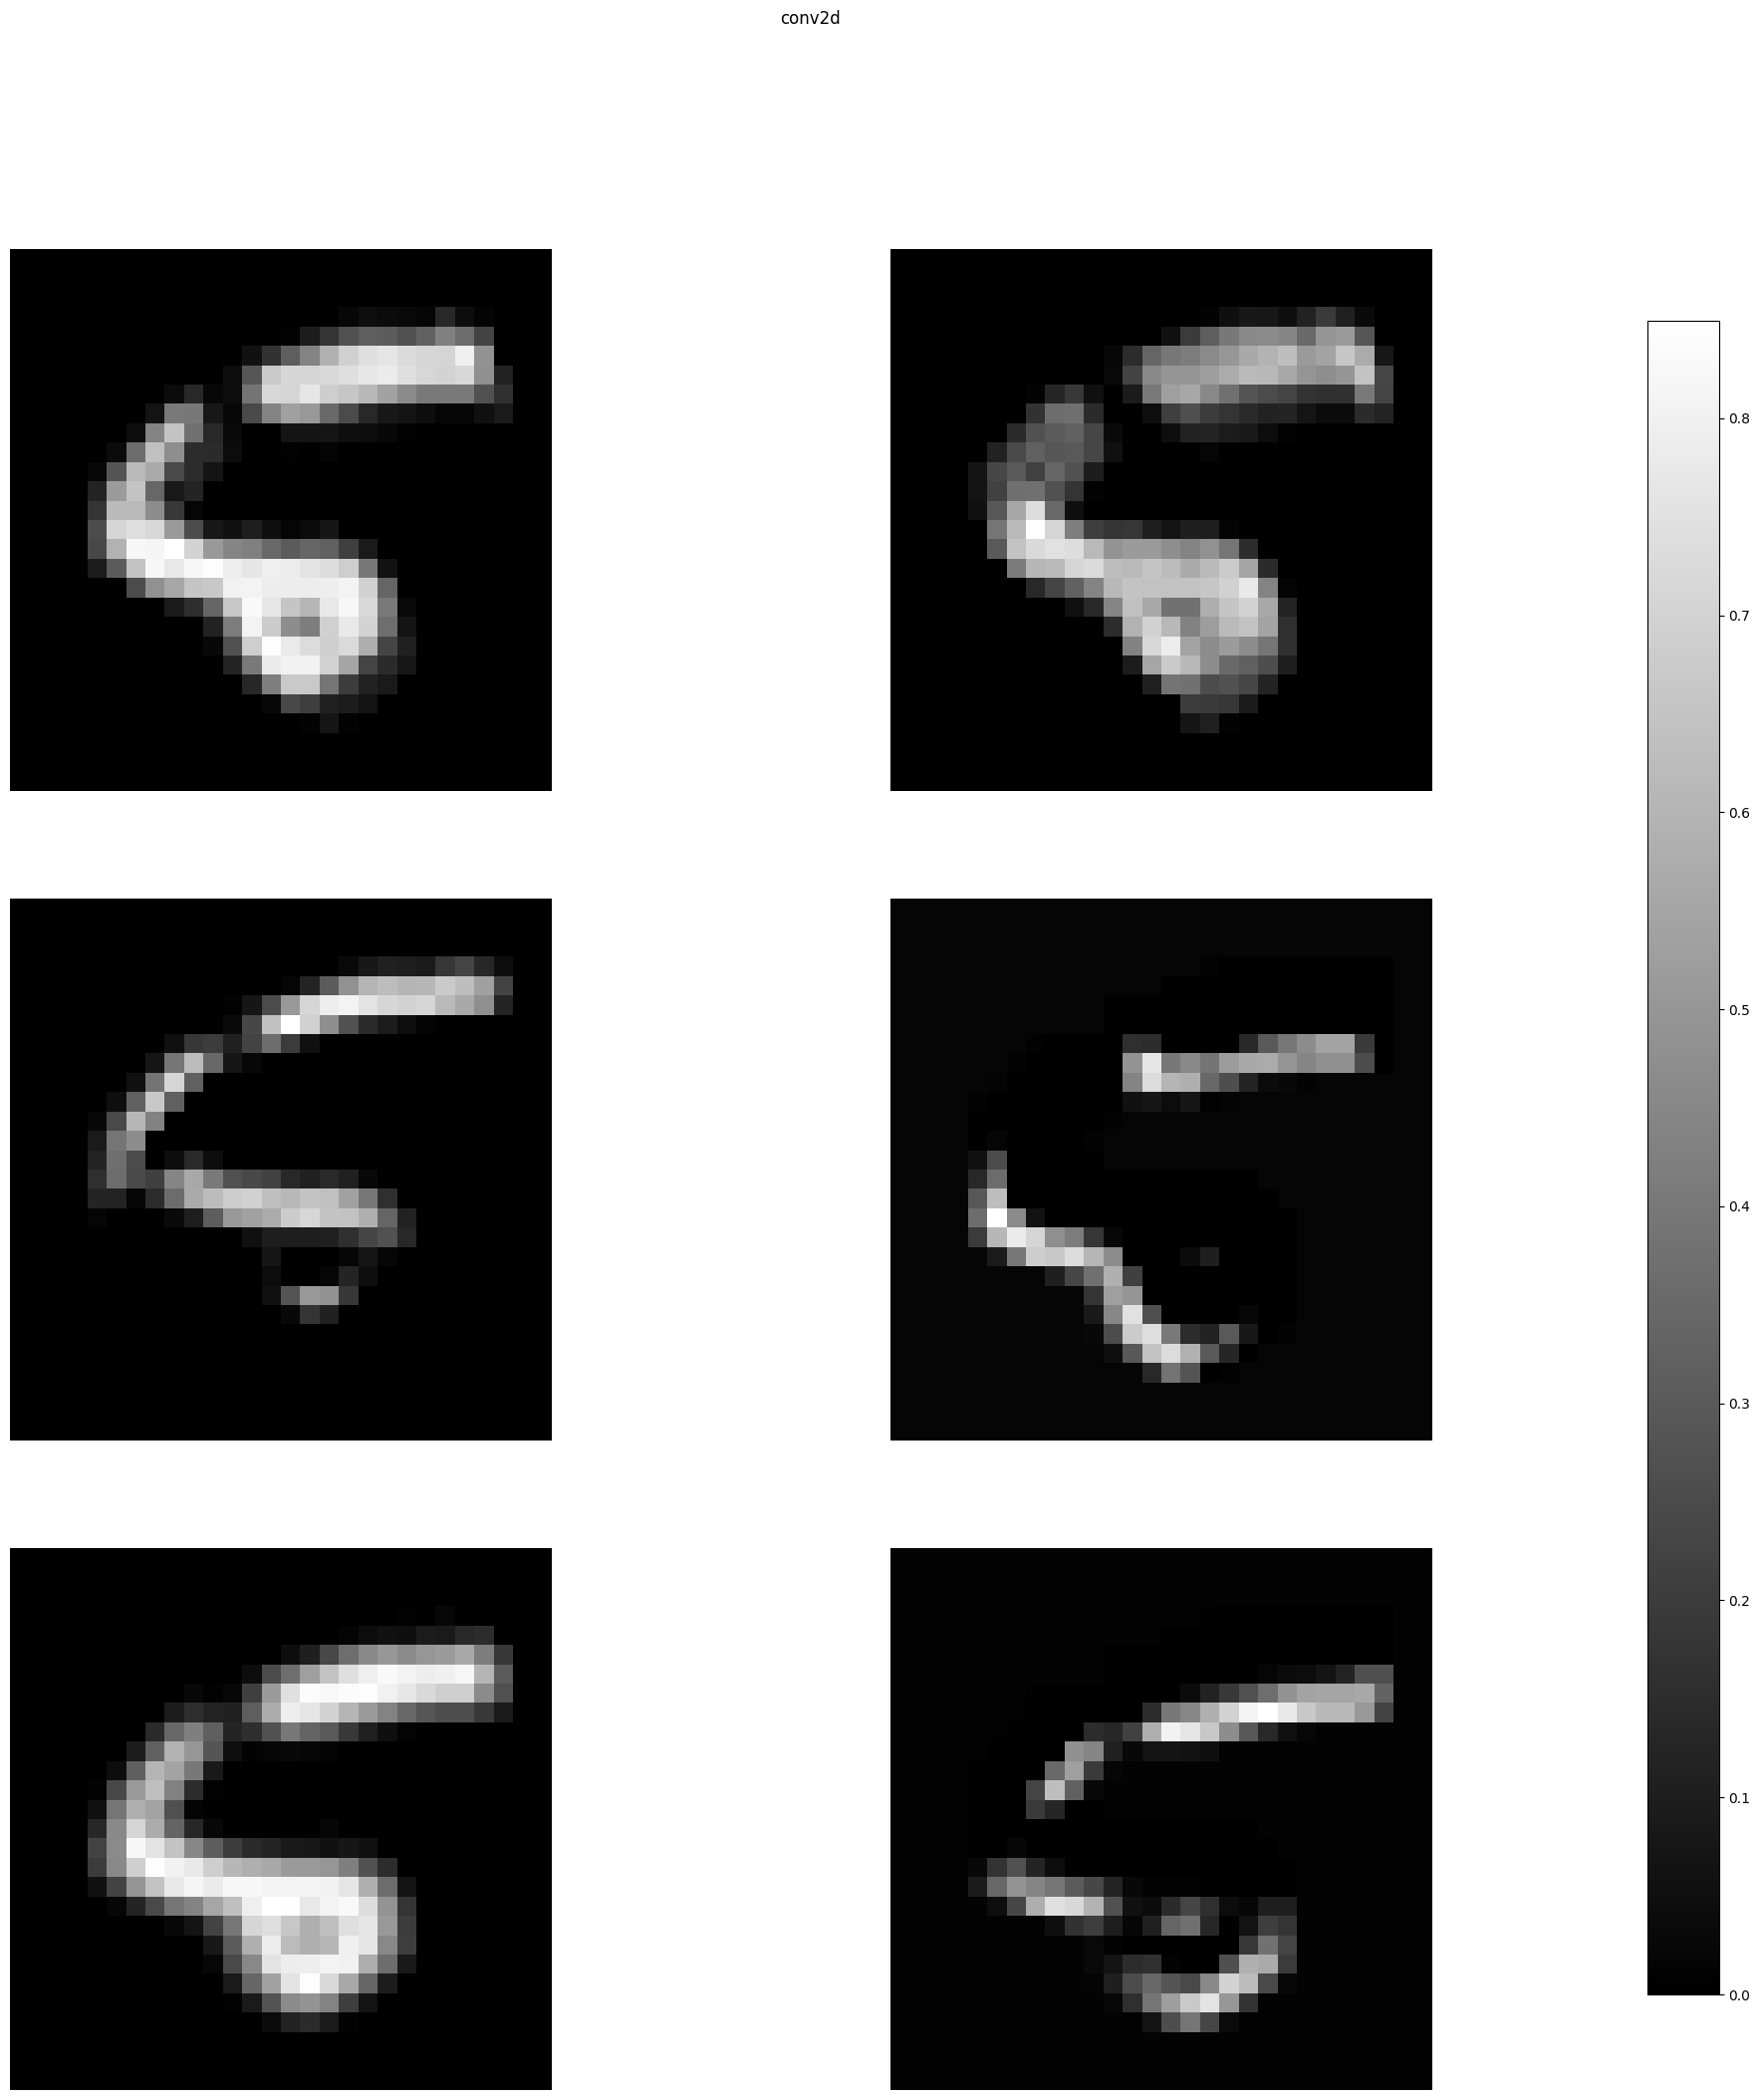

max_pooling2d (1, 14, 14, 6) 


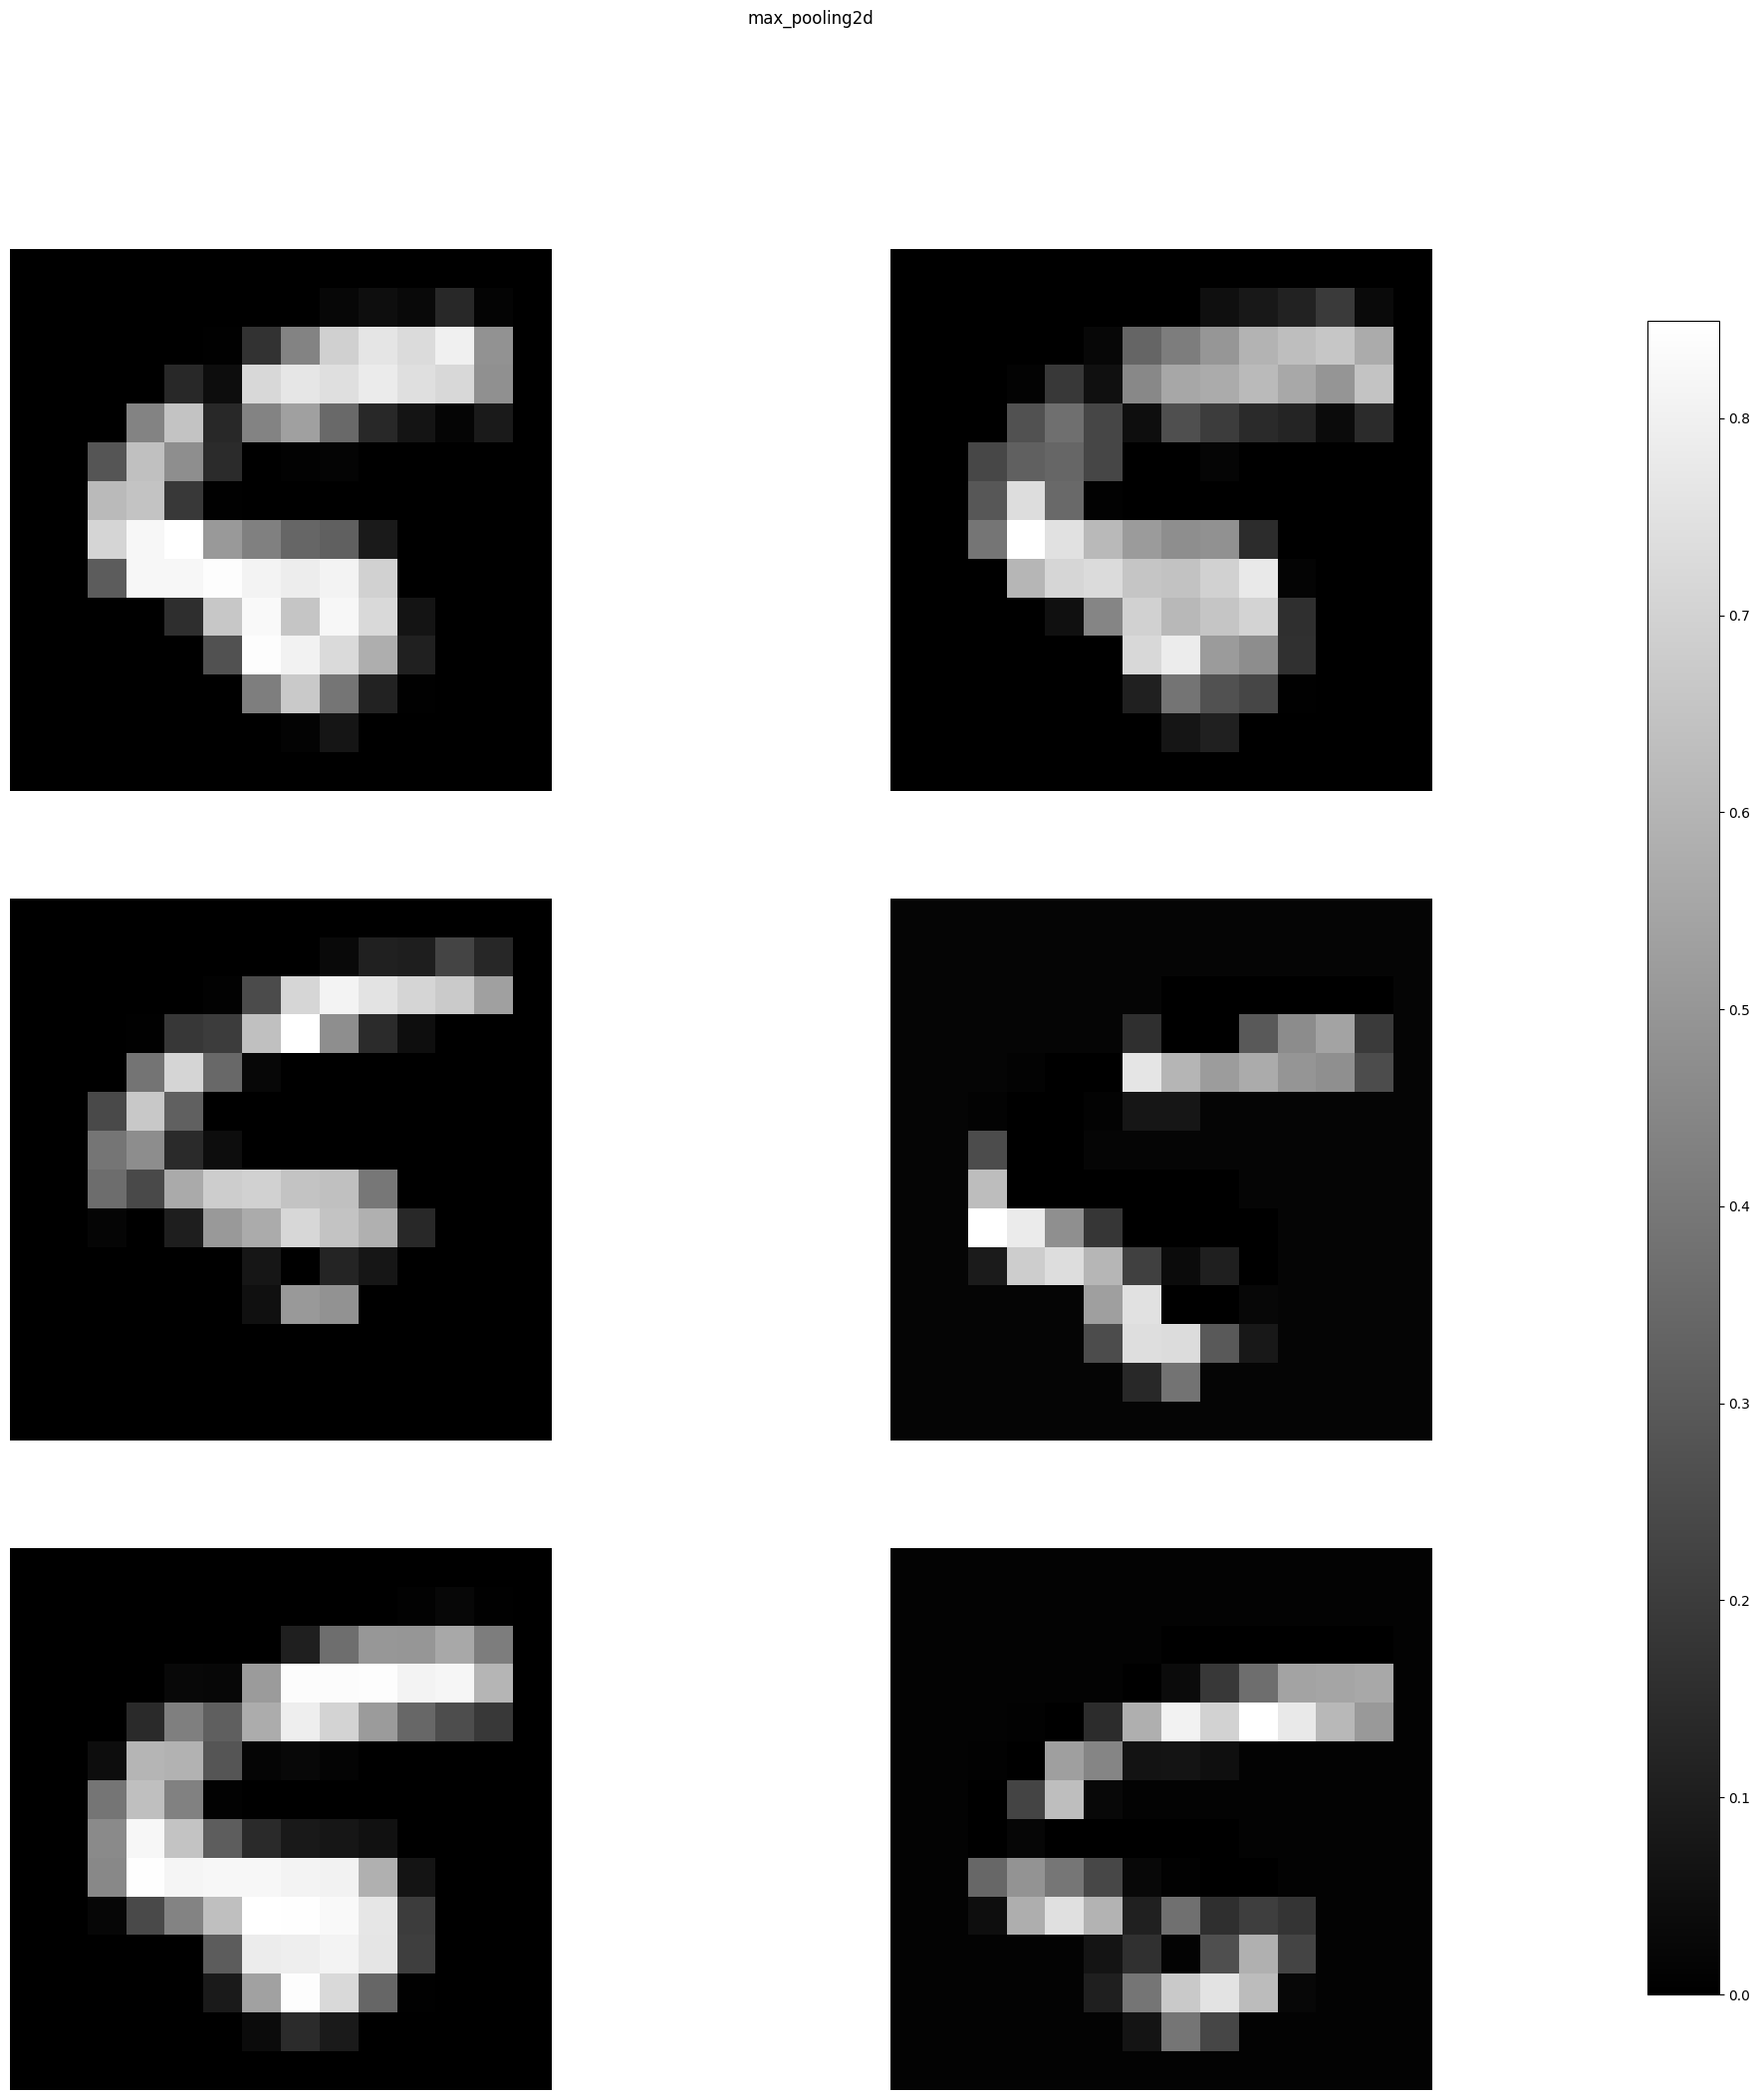

conv2d_1 (1, 14, 14, 10) 


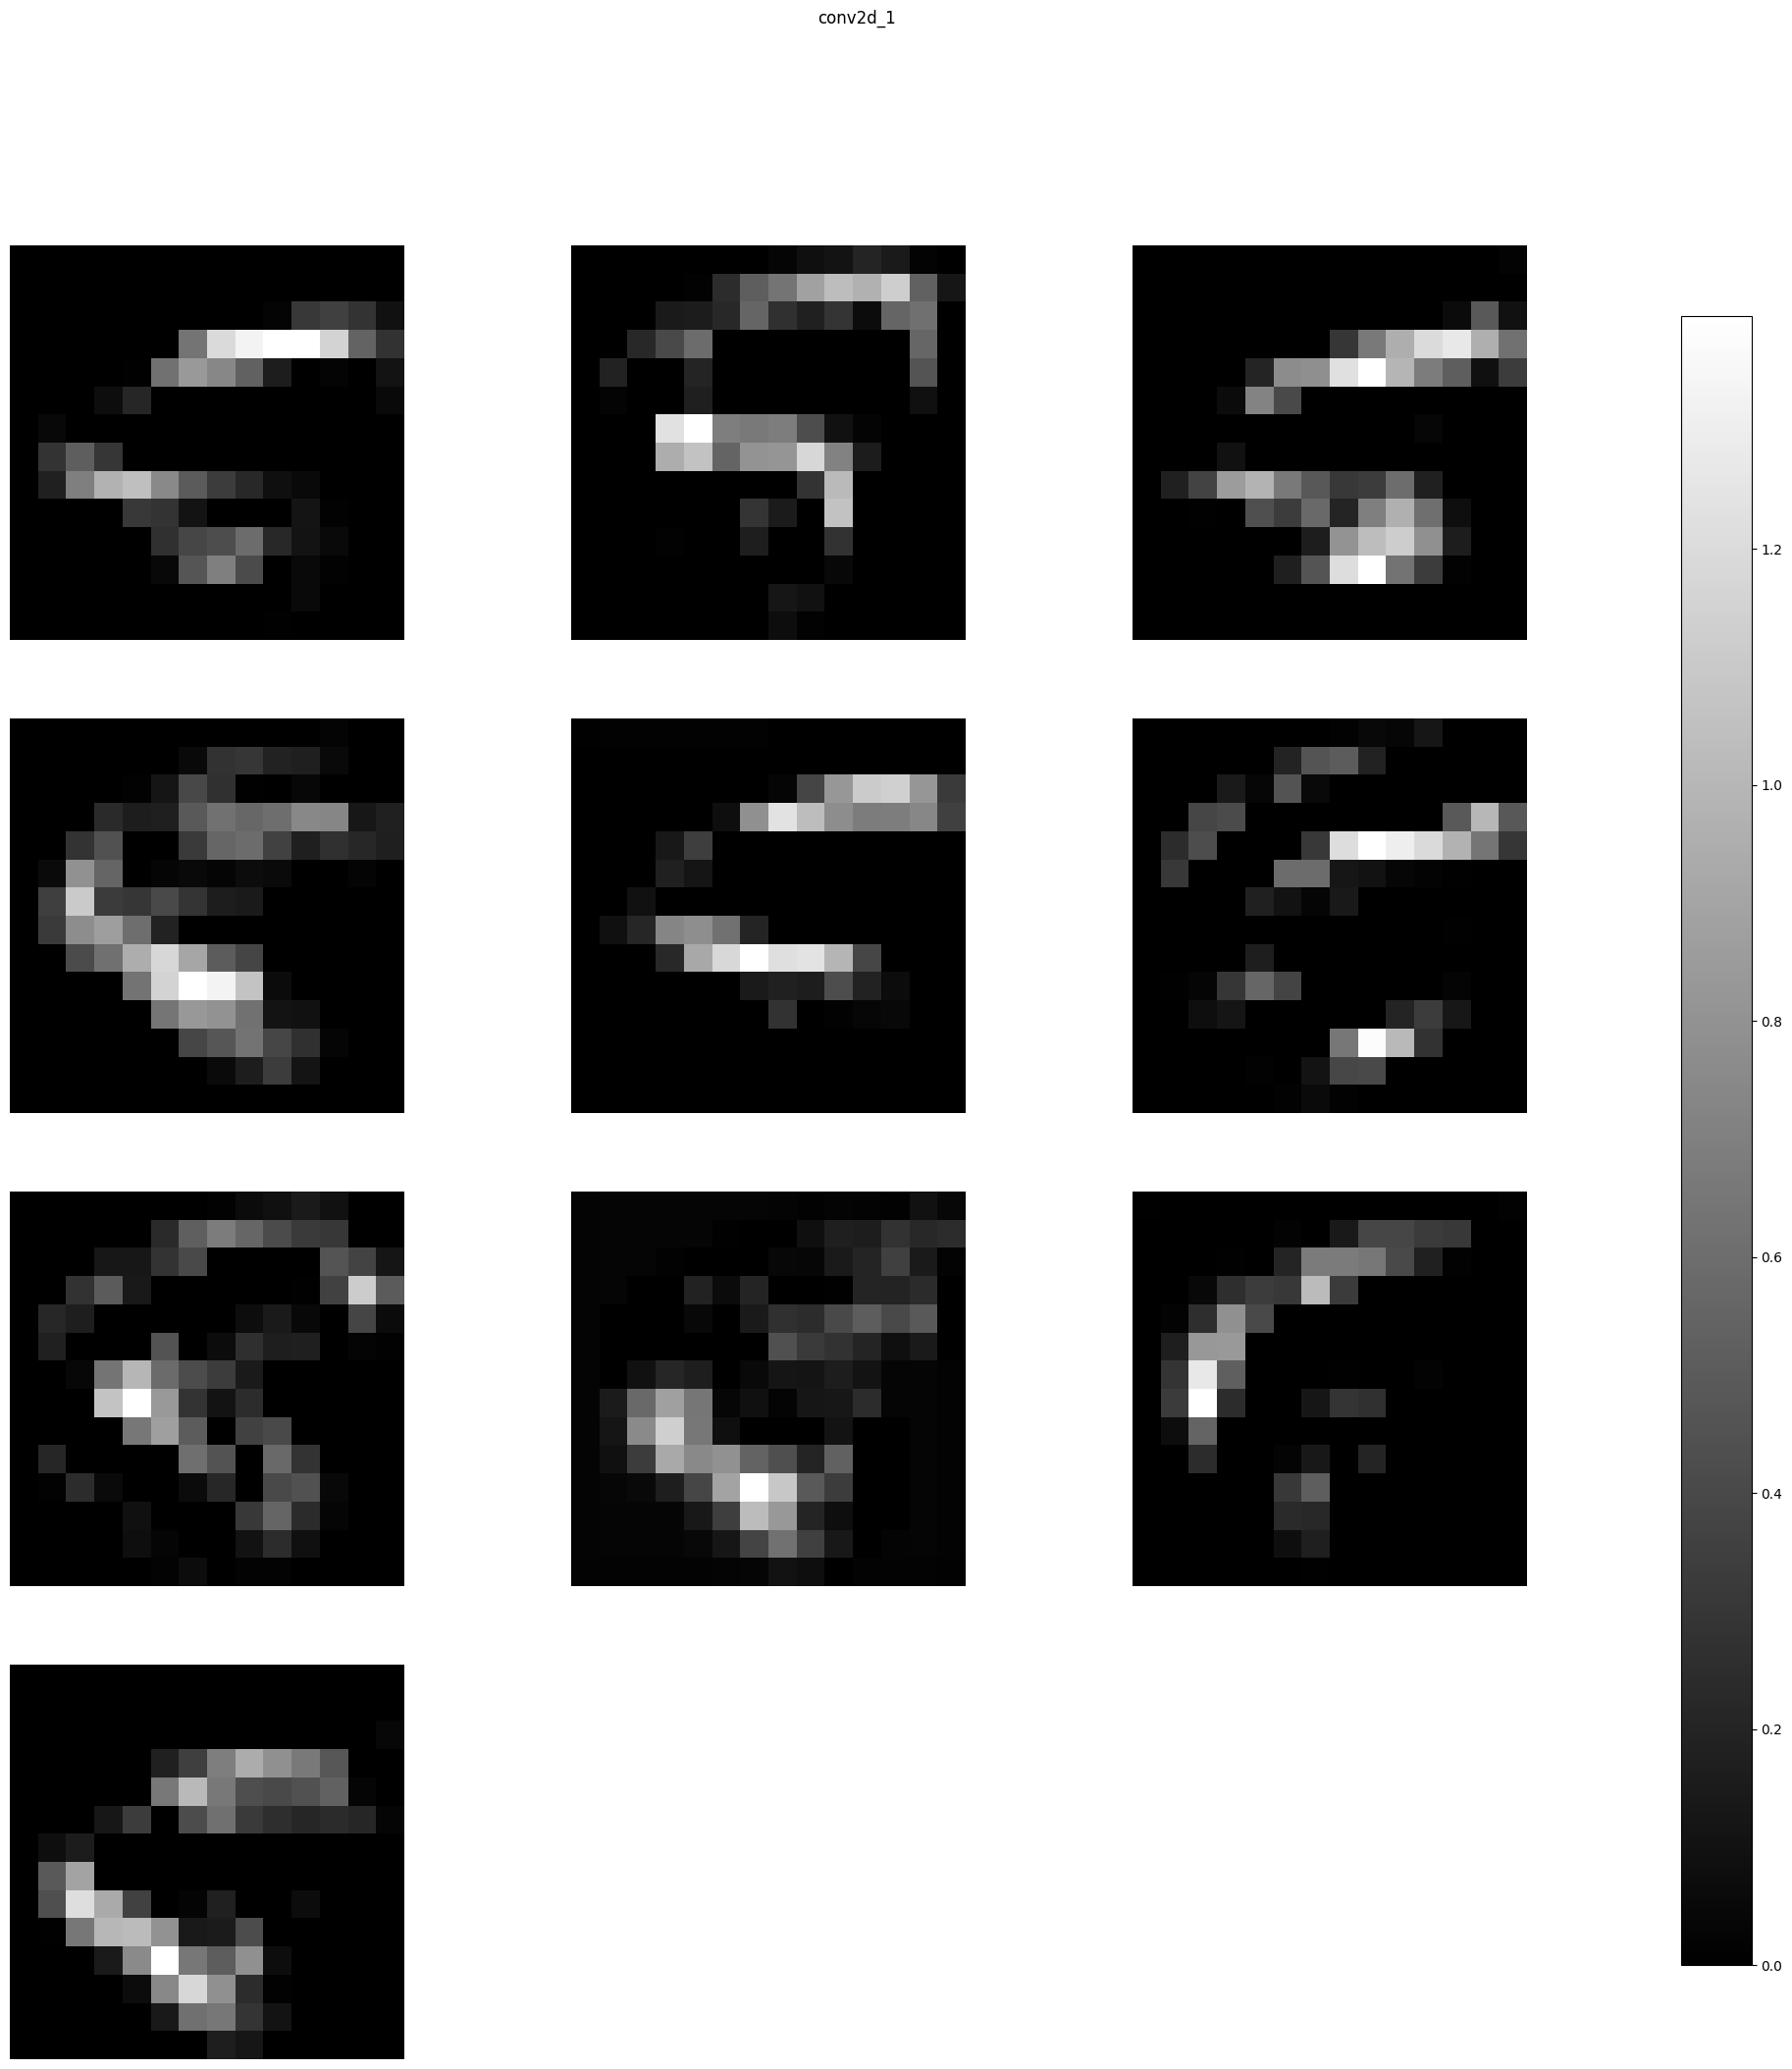

flatten (1, 1960) 


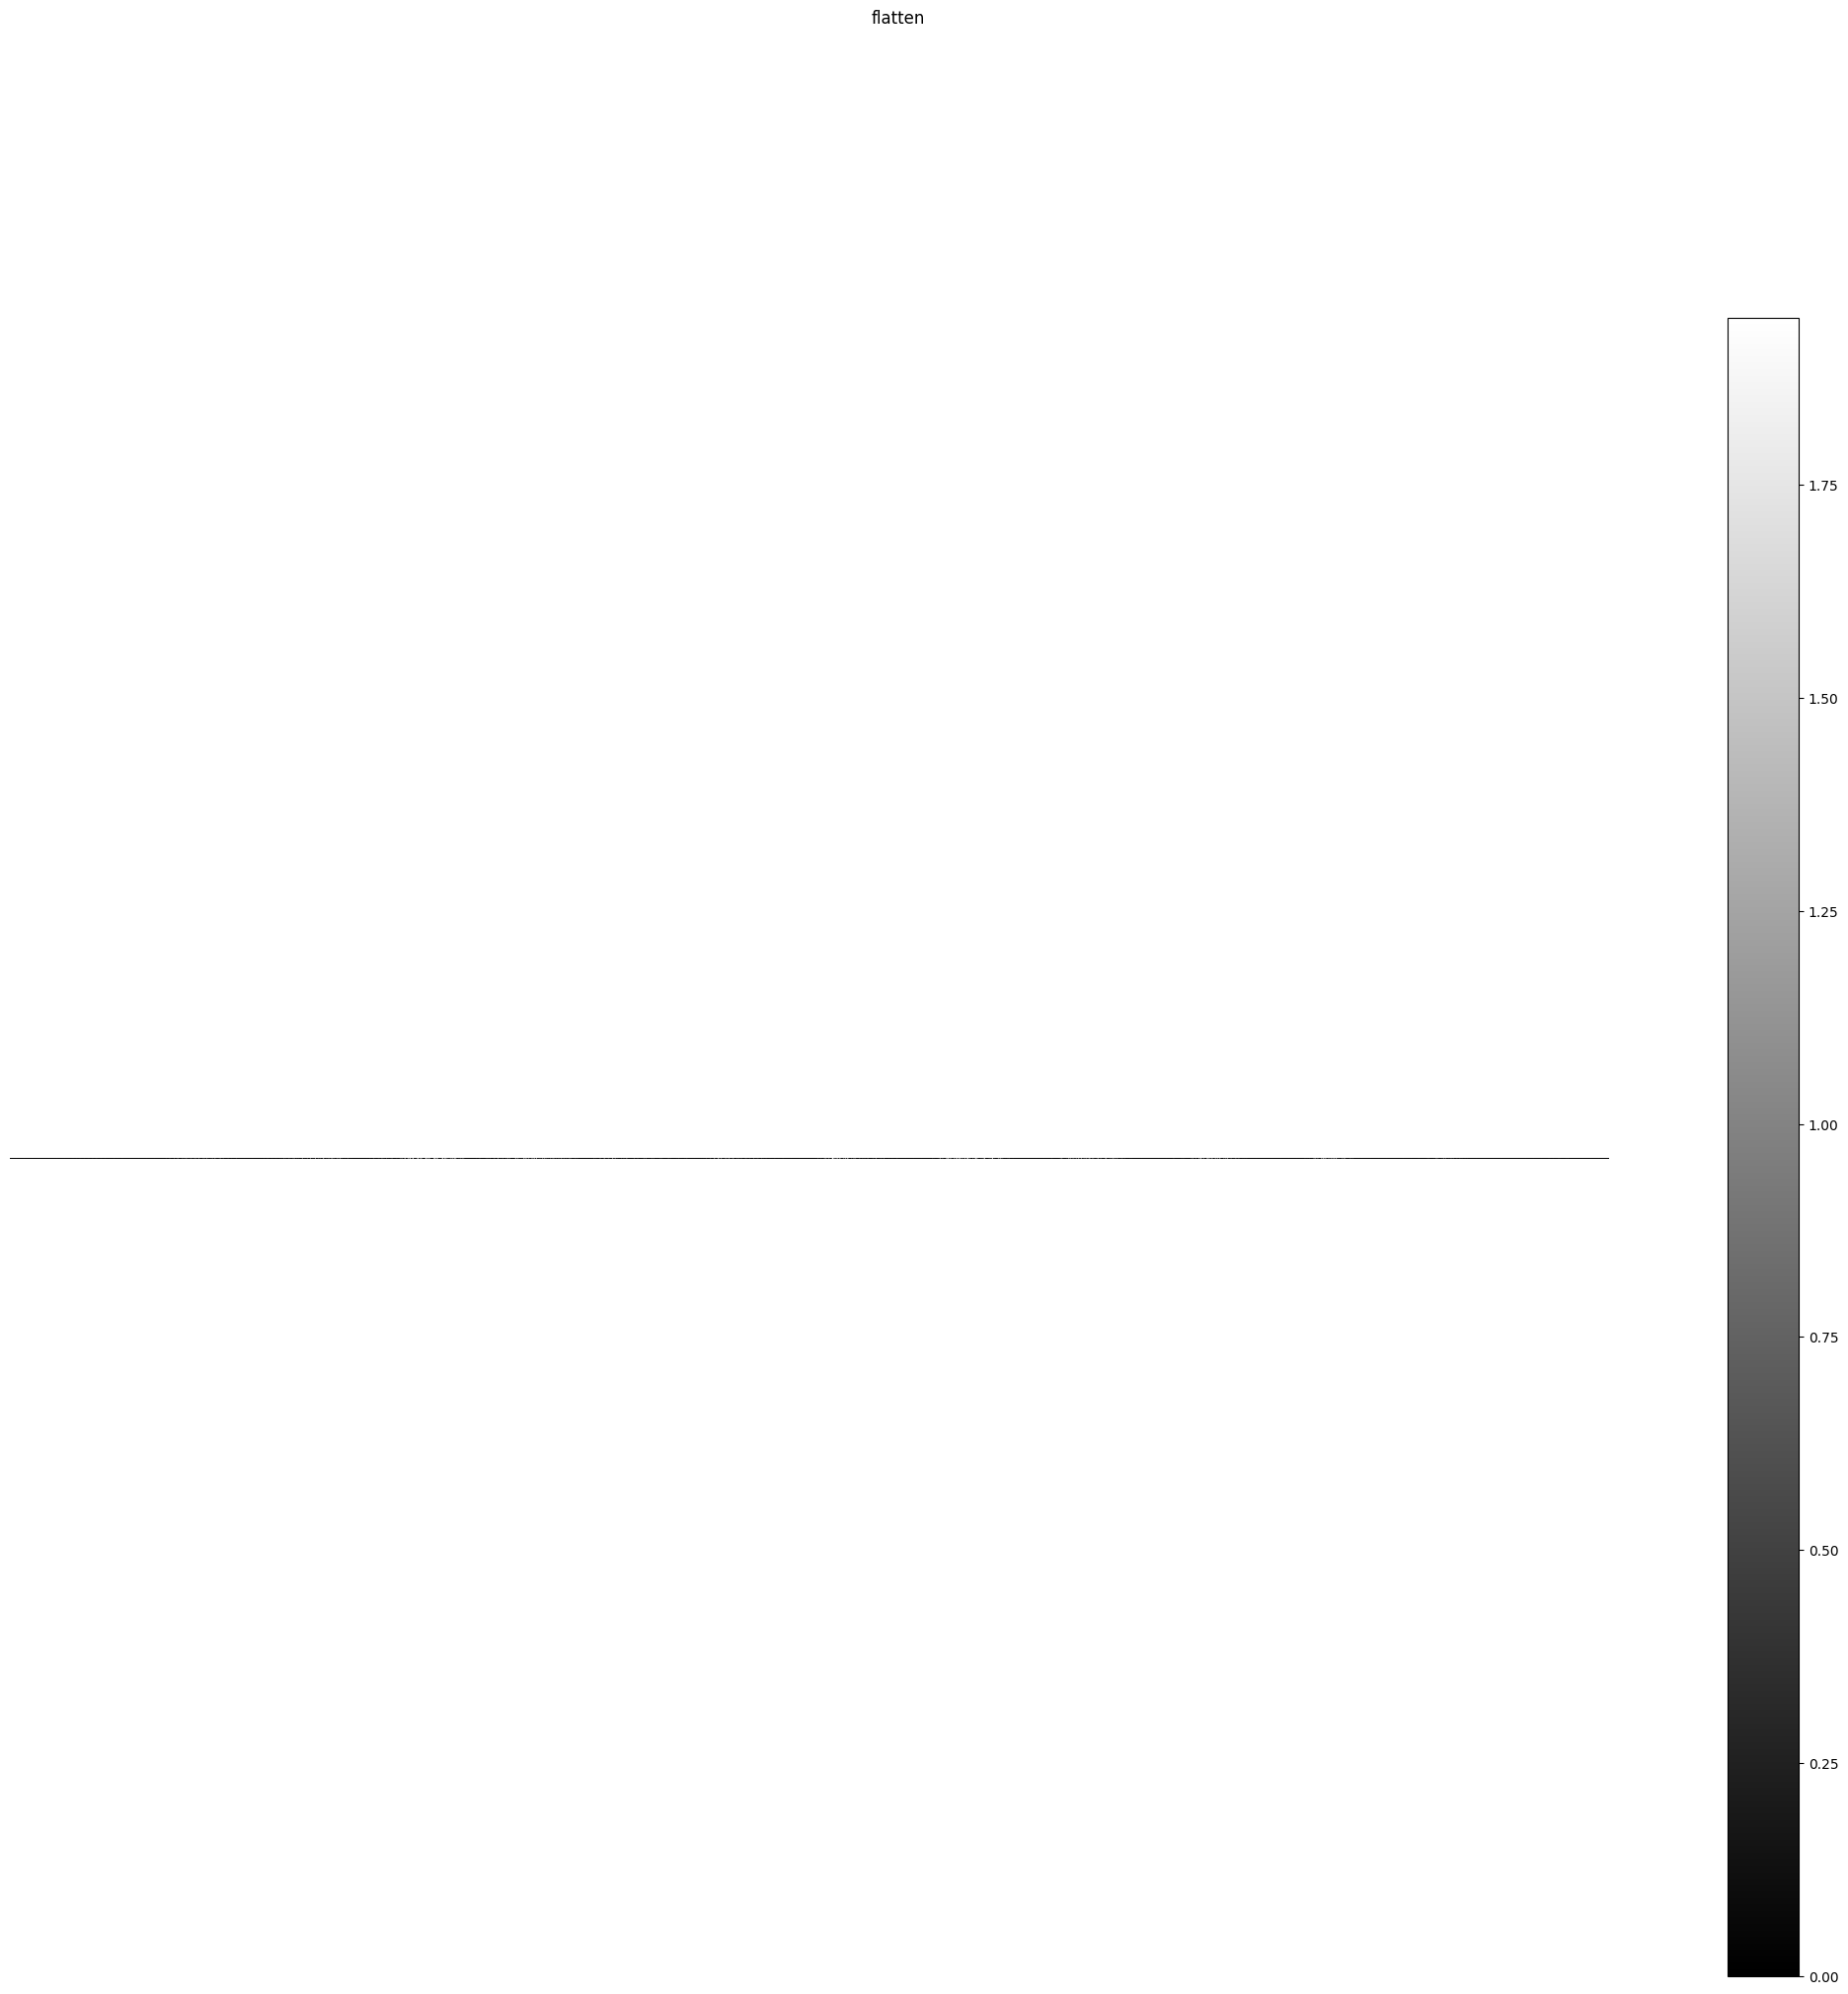

dense (1, 256) 


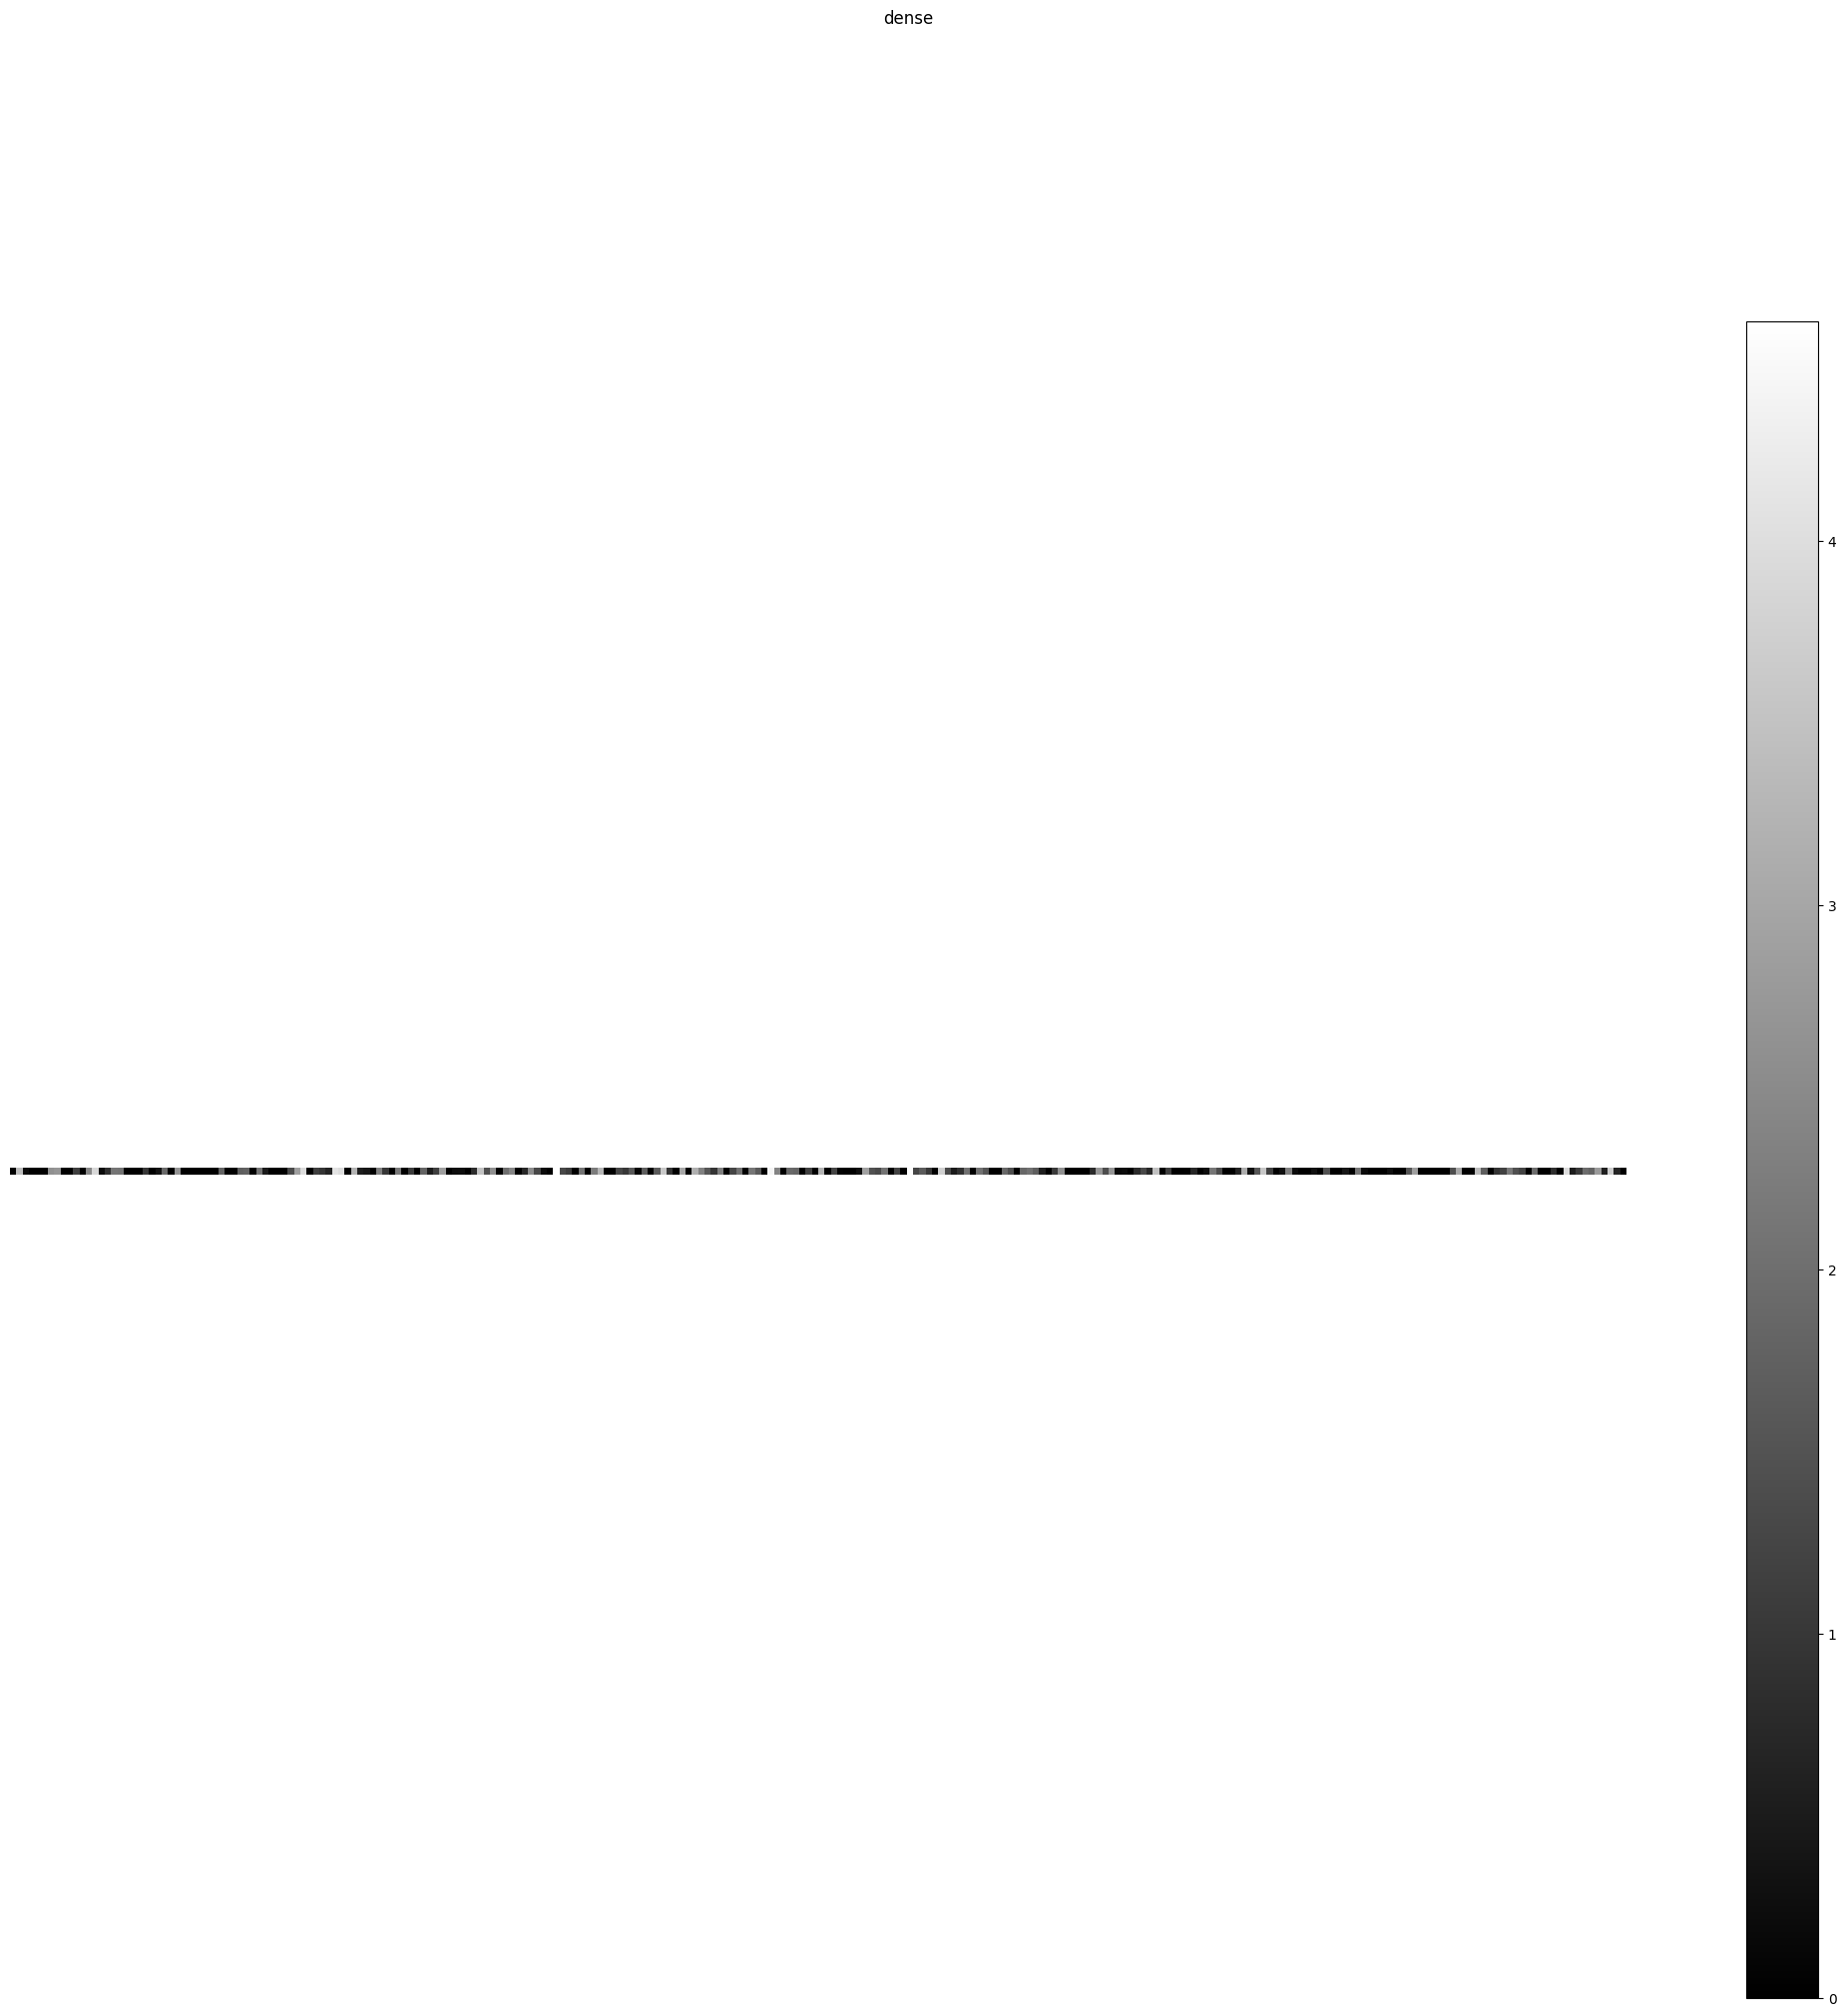

dense_1 (1, 10) 


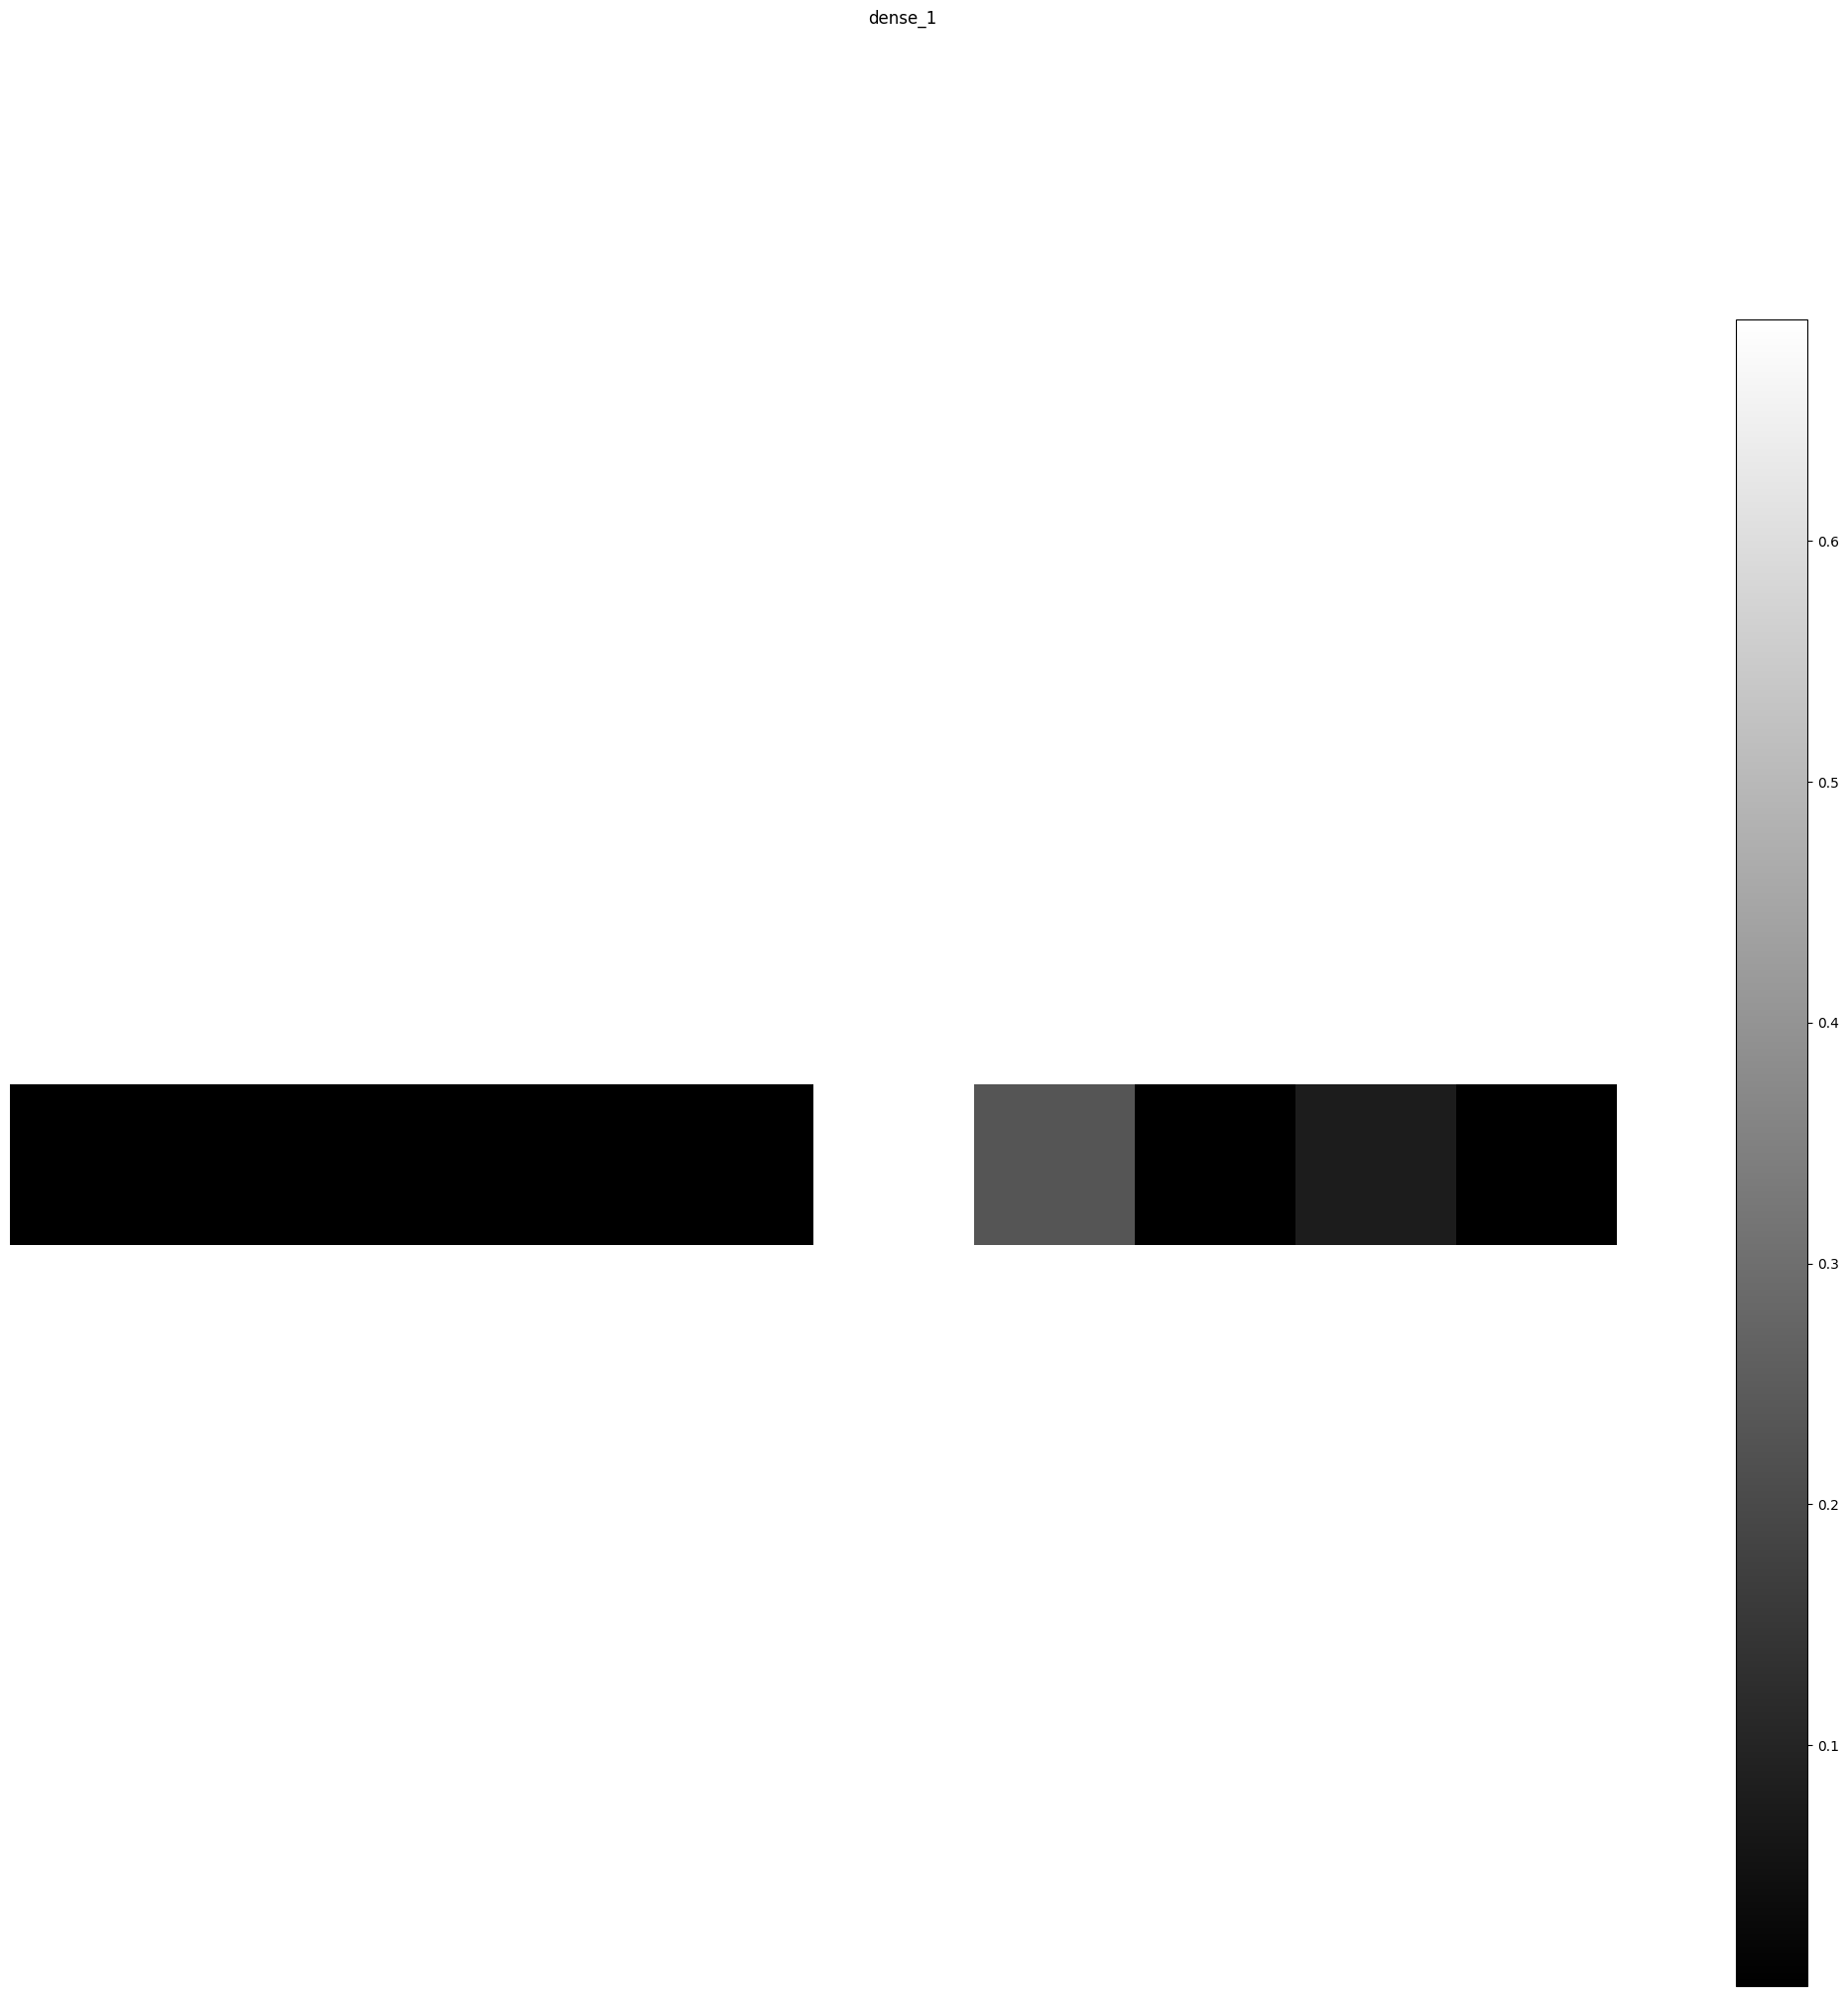

In [15]:
# Визуализируем активации с помощью keract.
# С помощью array slicing выделяем ещё какой-нибудь элемент из массива. (Результат должен также быть массивом.)
keract_inputs = input_test[8:9:1]
activations = get_activations(model, keract_inputs)
display_activations(activations, cmap="gray", save=False)